<a href="https://colab.research.google.com/github/lynn-he/Fun-Projects/blob/master/office_visualizations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [0]:
import pandas as pd
import json
import seaborn as sns
import re

#Reading/Cleaning The Office LInes CSV

In [4]:
#upload the office lines csv
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving the-office-lines - scripts.csv to the-office-lines - scripts.csv
User uploaded file "the-office-lines - scripts.csv" with length 5313478 bytes


In [2]:
df = pd.read_csv('the-office-lines - scripts.csv')
df.head()

,id,season,episode,scene,line_text,speaker,deleted
0,1,1,1,1,All right Jim. Your quarterlies look very good...,Michael,False
1,2,1,1,1,"Oh, I told you. I couldn't close it. So...",Jim,False
2,3,1,1,1,So you've come to the master for guidance? Is ...,Michael,False
3,4,1,1,1,"Actually, you called me in here, but yeah.",Jim,False
4,5,1,1,1,"All right. Well, let me show you how it's done.",Michael,False


####Removing deleted scenes, scene instructions, and restoring damaged data

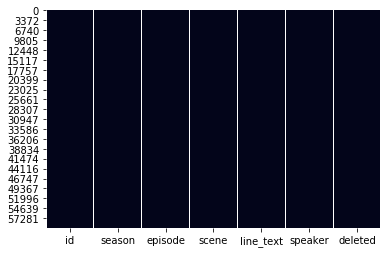

In [106]:
sns.heatmap(df.isnull(), cbar=False)

Looks like there are no null values! 

For the purpose of this project, I am not interested in the lines from deleted scenes. Let's also remove the scene instructions. Also, some encoding issue damaged the data. Some apostrophes have been converted into three � characters. We need to change them back.




   
   
If we visualize the head, there should be no scene instructions. Similarly, if we visualize the tail, there should be no unicode. 

In [3]:
#only keep scenes that weren't deleted
df = df[df.deleted == False] 

#check if all values in deleted are False
print(df.deleted.nunique() == 1) 

#fix the encoding issues, and remove any scene directions
df['line_text'] = df.line_text.apply(lambda row: re.sub("[\[].*?[\]]", "", row)\
                                 .replace("���", "'"))

#drop any lines that have no text, since some of them were only screen directions
df = df[df.line_text != '']
df.head()

True


,id,season,episode,scene,line_text,speaker,deleted
0,1,1,1,1,All right Jim. Your quarterlies look very good...,Michael,False
1,2,1,1,1,"Oh, I told you. I couldn't close it. So...",Jim,False
2,3,1,1,1,So you've come to the master for guidance? Is ...,Michael,False
3,4,1,1,1,"Actually, you called me in here, but yeah.",Jim,False
4,5,1,1,1,"All right. Well, let me show you how it's done.",Michael,False


#Getting the characters in each scene

In [49]:
df[df.speaker == 'Michael & Dwight']

,id,season,episode,scene,line_text,speaker,deleted
11671,11672,3,8,31,in the Electric City!,Michael & Dwight,False
30799,30800,6,1,1,Yeah! Gainer! Woohoo!,Michael & Dwight,False


In [53]:
scenes_df = df[(df.season == 1) & (df.episode == 1) & (df.scene == 1)]
speakers = scenes_df.speaker.unique()
# speakers = scenes_df.get_group(1)[df.scene == 1]
speakers

array(['Michael', 'Jim'], dtype=object)

In [52]:
speakers = speakers.tolist()

for speaker in speakers:
  if '&' in speaker:
    s1,_,s2 = speaker.partition('&')
    s1 = s1[:-1]
    s2 = s2[1:]
    if s1 not in speakers:
      speakers.append(s1)
    if s2 not in speakers:
      speakers.append(s2)
    speakers.remove(s1,s2)
  
speakers

['Michael', 'Jim']

In [0]:


for s in range(len(df.season.unique())):
  for e in range(len(df[df.season == s+1].episode.unique())):
    for scene in range(len(df[(df.season == s+1) & (df.episode == e+1)].scene.unique())):
      scenes_df = df[(df.season == s+1) & (df.episode == e+1) & (df.scene == scene+1)]
      speakers = scenes_df.speaker.unique().tolist()
      for speaker in speakers:
        if '&' in speaker:
          s1,_,s2 = speaker.partition('&')
          s1 = s1[:-1]
          s2 = s2[1:]
          if s1 not in speakers:
            speakers.append(s1)
          if s2 not in speakers:
            speakers.append(s2)
          speakers.remove(s1,s2)
          

#Google Perspective API

In [0]:
import requests

Upload a txt file with: {api_key: **your key here**}

In [48]:
#upload google perspectives api key
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving api_key.txt to api_key.txt
User uploaded file "api_key.txt" with length 55 bytes


In [0]:
api_key = json.loads(open('api_key.txt').read())['api_key']

##Find toxicity score of each line



Note: Analysis requests limit (AnalyzeComment) per 100 seconds is **100**

Saving output into a json so you don't have to use the API everytime!

In [0]:
import time

def tox_score(row):
  print(row.id)
  
  payload_data = {"comment": {"text": row.line_text},
      "languages": ["en"],
      "requestedAttributes" : {"TOXICITY":{},
                               "SEVERE_TOXICITY":{},
                               "IDENTITY_ATTACK":{},
                               "INSULT":{}, 
                               "PROFANITY":{},
                               "SEXUALLY_EXPLICIT":{},
                               "THREAT":{}, 
                               "FLIRTATION": {}, 
                               "OBSCENE": {}, 
                               "INFLAMMATORY":{}} }
  payload = json.dumps(payload_data)
  headers = {'content-type': "application/json"}

  endpoint = '''https://commentanalyzer.googleapis.com/v1alpha1/comments:analyze?key={}'''
  url = endpoint.format(api_key)
  
  response = (requests.post(url, data = payload, headers = headers)).json()
  
  flirtation = response['attributeScores']['FLIRTATION']['summaryScore']['value']
  identity_attack = response['attributeScores']['IDENTITY_ATTACK']['summaryScore']['value']
  insult = response['attributeScores']['INSULT']['summaryScore']['value']
  obscene = response['attributeScores']['OBSCENE']['summaryScore']['value']
  profanity = response['attributeScores']['PROFANITY']['summaryScore']['value']
  severe_toxicity = response['attributeScores']['SEVERE_TOXICITY']['summaryScore']['value']
  sexually_explicit = response['attributeScores']['SEXUALLY_EXPLICIT']['summaryScore']['value']
  threat = response['attributeScores']['THREAT']['summaryScore']['value']
  toxicity = response['attributeScores']['TOXICITY']['summaryScore']['value']
  detected_language = response['detectedLanguages'][0]
  
  keys = ['flirtation', 'identity_attack',
          'insult', 'obscene','profanity','severe_toxicity',
          'sexually_explicit','threat','toxicity','detected_language']
  values = [flirtation, identity_attack, insult, obscene, profanity, 
            severe_toxicity, sexually_explicit, threat, toxicity, detected_language]
  
  scores = dict(zip(keys, values))
  
  with open('toxicity_scores.json', 'w+') as f:
    data = json.load(f)
    data[str(row.id)] = scores 
    f.seek(0)      
    json.dump(data, f)
    f.truncate()  
      
  time.sleep(1)
  return scores

###Season 1

In [0]:
df_s1 = df[df.season == 1]
df_s1.apply(tox_score, axis = 1)

Now we have a json with all the scores. Let's change it to a DataFrame.

In [0]:
#upload toxicity_scores.json if you already ran the function!
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [0]:
import json 
import pandas as pd

json_file = open('s1_toxicity_scores.json')
json_str = json_file.read()
json_data = json.loads(json_str)
df1 = pd.DataFrame.from_dict(json_data)
df1 = df1.T
df1.index = df1.index.astype(str).astype(int)

Let's merge it with the season 1 DataFrame.

In [0]:
df_s1.set_index('id', inplace = True)
df_s1 = pd.concat([df_s1, df1], axis = 1)
df_s1.head()

In [0]:
df_s1.head(2)

In [0]:
df_s1[['flirtation', 'identity_attack','insult','obscene',
      'profanity','severe_toxity','sexually_explicit','threat','toxicity']] \
= df_s1[['flirtation', 'identity_attack','insult','obscene',
      'profanity','severe_toxity','sexually_explicit','threat','toxicity']].apply(pd.to_numeric)

#IBM Watson Natural Language Understanding API

##Sentiment analysis on Pam and her feelings towards Jim

1. Get dataframe with just Pam's lines
2. Run sentiment analysis on all her lines
3. Plot per scene

**1.** Get dataframe with just Pam's lines.

In [158]:
df_pam = df[df.speaker == 'Pam']
df_pam.head(3)

,id,season,episode,scene,line_text,speaker,deleted
7,8,1,1,3,Well. I don't know.,Pam,False
9,10,1,1,3,What?,Pam,False
11,12,1,1,3,"Uh, yeah. Just a fax.",Pam,False


**2.** Run sentiment analysis on all her lines

In [7]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving watson_api_key.txt to watson_api_key (1).txt
User uploaded file "watson_api_key.txt" with length 140 bytes


In [0]:
api_key = json.loads(open('watson_api_key.txt').read())['api_key']
url = json.loads(open('watson_api_key.txt').read())['url']

In [0]:
!pip install --upgrade watson-developer-cloud

Now let's analyze all of her lines.

Note: API limit of 30,000 per month

In [0]:
from watson_developer_cloud import NaturalLanguageUnderstandingV1
from watson_developer_cloud.natural_language_understanding_v1 import Features, SentimentOptions, EmotionOptions

def get_sentiment(row):
  print(row.id)
  natural_language_understanding = NaturalLanguageUnderstandingV1(
      version='2018-11-16',
      iam_apikey= api_key,
      url = url
  )

  #analyzing on a document level and with respect to Jim :)
  try:
    #document level sentiment analysis
    response = natural_language_understanding.analyze(
        text= row.line_text, #pass in line
#         text= "I love that guy  so much wow i want to marry him!",
        features=Features(sentiment=SentimentOptions(document = True))).get_result() 
    sentiment_doc = response['sentiment']['document']['score']
#     print(json.dumps(response, indent=2))
  except:
    sentiment_doc = float('nan')

  try:
    #sentiment analysis wrt a target
    response = natural_language_understanding.analyze(
        text= row.line_text, #pass in line
#         text= "I love that guy  so much wow i want to marry him!",
        features=Features(sentiment=SentimentOptions(targets = ['Jim']))).get_result()
    sentiment_target = response['sentiment']['targets'][0]['score']
#     print(json.dumps(response, indent=2))
  except:
    sentiment_target = float('nan')

  try:
    #emotions analysis wrt a target
    response = natural_language_understanding.analyze(
        text= row.line_text, #pass in line
#         text= "I love that guy  so much wow i want to marry him!",
        features=Features(emotion=EmotionOptions(targets = ['Jim']))).get_result()
    sadness = response['emotion']['document']['emotion']['sadness']
    joy = response['emotion']['document']['emotion']['joy']
    fear = response['emotion']['document']['emotion']['fear']
    disgust = response['emotion']['document']['emotion']['disgust']
    anger = response['emotion']['document']['emotion']['anger']
    target_sadness = response['emotion']['targets'][0]['emotion']['sadness']
    target_joy = response['emotion']['targets'][0]['emotion']['joy']
    target_fear = response['emotion']['targets'][0]['emotion']['fear']
    target_disgust = response['emotion']['targets'][0]['emotion']['fear']
    target_anger = response['emotion']['targets'][0]['emotion']['anger']
#     print(json.dumps(response, indent=2))
  except:
    sadness = float('nan')
    joy = float('nan')
    fear = float('nan')
    disgust = float('nan')
    anger = float('nan')
    target_sadness = float('nan')
    target_joy = float('nan')
    target_fear = float('nan')
    target_disgust = float('nan')
    target_anger = float('nan')


  keys = ['sentiment_target','sentiment_doc','sadness','joy','fear','disgust',
         'anger','target_sadness','target_joy','target_fear','target_disgust','target_anger']
  values = [sentiment_target, sentiment_doc, sadness, joy, fear, disgust, anger,
           target_sadness, target_joy, target_fear, target_disgust, target_anger]

  scores = dict(zip(keys, values))

  with open('pam_sentiment.json', 'a+') as f:
    try:
      data = json.load(f)
      data[str(row.id)] = scores 
      f.seek(0)      
      json.dump(data, f)
      f.truncate()
    except:
      data = {}
      data[str(row.id)] = scores 
      json.dump(data, f)
# print(scores)
# print(json.dumps(response, indent=2))

In [0]:
df_pam.apply(get_sentiment, axis = 1)

Now we have the json of all the scores. First let's get that into a dataframe and visualize all of the null values. 

In [145]:
import json 
import pandas as pd

json_file = open('pam_sentiment.json')
json_str = json_file.read()
json_data = json.loads('[' + json_str.replace('}{', '},{') + ']')
super_dict = {}
for d in json_data:
    for k, v in d.items(): 
         super_dict[k] = v
df1 = pd.DataFrame.from_dict(super_dict)
df1 = df1.T
df1.index = df1.index.astype(str).astype(int)
df1.head()

,anger,disgust,fear,joy,sadness,sentiment_doc,sentiment_target,target_anger,target_disgust,target_fear,target_joy,target_sadness
8,NaN,NaN,NaN,NaN,NaN,0.00000,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,NaN,NaN,NaN,NaN,NaN,0.63721,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,0.00000,NaN,NaN,NaN,NaN,NaN,NaN
38,NaN,NaN,NaN,NaN,NaN,0.00000,NaN,NaN,NaN,NaN,NaN,NaN


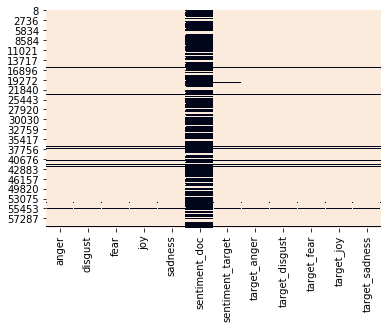

In [163]:
import seaborn as sns

sns.heatmap(df1.isnull(), cbar=False)
plt.show()

Let's merge it with the orginal dataframe. 

In [159]:
df_copy = df_pam.copy()
df_copy.set_index('id', inplace = True)
pam_scores = pd.concat([df_copy, df1], axis = 1)
pam_scores.head(2)

,season,episode,scene,line_text,speaker,deleted,anger,disgust,fear,joy,sadness,sentiment_doc,sentiment_target,target_anger,target_disgust,target_fear,target_joy,target_sadness
8,1,1,3,Well. I don't know.,Pam,False,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
10,1,1,3,What?,Pam,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now we can visualize the results. 

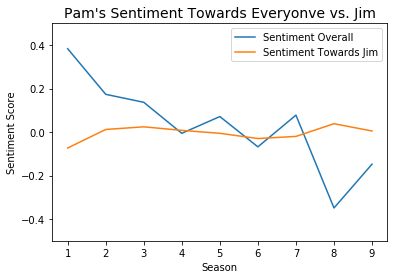

In [160]:
import matplotlib.pyplot as plt
import seaborn as sns

pam_jim_df = pam_scores[pam_scores.sentiment_target.notnull()].groupby(['season'],as_index=False)['sentiment_target'].mean()
pam_sentiment_df = pam_scores[pam_scores.sentiment_doc.notnull()].groupby(['season'],as_index=False)['sentiment_doc'].mean()

sns.lineplot(pam_jim_df.season, pam_jim_df.sentiment_target)
sns.lineplot(pam_sentiment_df.season, pam_sentiment_df.sentiment_doc)

plt.legend(labels=['Sentiment Overall', 'Sentiment Towards Jim'])
plt.title('Pam\'s Sentiment Towards Everyonve vs. Jim', fontsize = 14)
plt.xlabel('Season', fontsize=10)
plt.ylabel('Sentiment Score', fontsize=10)
plt.ylim((-.5,.5))
plt.show()

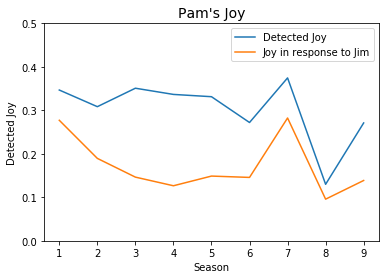

In [161]:
pam_joy = pam_scores[pam_scores.joy.notnull()].groupby(['season'],as_index=False)['joy'].mean()
pam_jim_joy = pam_scores[pam_scores.target_joy.notnull()].groupby(['season'],as_index=False)['target_joy'].mean()

sns.lineplot(pam_joy.season, pam_joy.joy)
sns.lineplot(pam_jim_joy.season, pam_jim_joy.target_joy)

plt.legend(loc='upper right',labels=['Detected Joy', 'Joy in response to Jim'])
plt.xlabel('Season', fontsize=10)
plt.ylabel('Detected Joy', fontsize=10)
plt.title('Pam\'s Joy', fontsize=14)
plt.ylim((0,.5))
plt.show()

Seems like season 8 is a low point for Jim and Pam so let's see whats happening there. 

In [176]:
pd.set_option('display.max_colwidth', -1)
pam_scores[(pam_scores.season == 8)  
           & (pam_scores.line_text.str.contains('Jim'))].filter(['line_text','sentiment_doc','sentiment_target'])

,line_text,sentiment_doc,sentiment_target
45764,Jim.,NaN,NaN
45888,"Oh, text from Jim. 'This is getting very weird. Will explain later.'",-0.262905,0.000000
45940,"Okay. Oh, uh, you dropped something. Jim?",0.000000,0.000000
45971,Oh! Text from Jim. 'This is...' hmm.,-0.631493,0.000000
46965,"I don't know what to tell you, Jim, but I saw a ghost.",-0.532433,0.000000
47110,Jim doesn't let me wash his NFL jersey during the playoffs. How is this any less logical?,-0.775386,-0.753628
47138,"I'm not gonna freak her out, Jim.",-0.679489,-0.679489
47647,Hmm. I think Jim's lying to me about not being attracted to Cathy.,-0.678012,-0.696504
47699,I don't think Jim cares about his hair.,-0.791115,-0.791115
47702,Jim's on to me.,0.000000,0.000000
